<a href="https://colab.research.google.com/github/yaosongsustech/smooth_grape/blob/master/%E2%80%9Ctf_grape_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qutip
!pip install scipy

**相关参数**

In [ ]:
from qutip import * 
import tensorflow as tf
import numpy as np
np.set_printoptions(threshold=np.inf)
# parameter
a_dag = create(3)
a = destroy(3)
b_dag = create(4)
b = destroy(4)
i3 = identity(3)
i4 = identity(4)
wc = 6.99 * 2 * np.pi
w1 = 5.47 * 2 * np.pi
w2 = 5.7 * 2 * np.pi
u1 = 0.249 * 2 * np.pi
u2 = 0.249 * 2 * np.pi
wcq = 0.151 * 2 * np.pi
wd = 5.4689 * 2 * np.pi
nt = 148
row_num = [0, 1, 4, 5] # 对应的计算子空间为 00,01,10,11
U_ideal = tensor(sigmax(), identity(2))
tg = 98.6
dt = tg / nt
twait = np.array([-15, 3.5, 1.5])
t0 = twait[0]
tglist = np.array([39., 0.4 * 39, 39.])

**计算系统哈密顿量**

In [ ]:
# 计算系统哈密顿量
# cavity
hc = wc * tensor(a_dag * a, i4, i4)
# qubit1
hq1 = w1 * tensor(i3, b_dag * b, i4) - u1/2 * tensor(i3, (b_dag * b) ** 2 - b_dag * b, i4)
# qubit2
hq2 = w2 * tensor(i3, i4, b_dag * b) - u2/2 * tensor(i3, i4, (b_dag * b) ** 2 - b_dag * b)
# couple
hcoup = wcq * tensor(a_dag, b, i4) +wcq * tensor(a_dag, i4, b) + wcq * tensor(a, b_dag, i4) + wcq * tensor(a, i4, b_dag)
h_sys = hc + hq1 + hq2 + hcoup

**本征基矢和计算子空间**

In [ ]:
# diagnalize
w, v=np.linalg.eigh(h_sys) 
h_diag = Qobj(np.diag(w))
h_diag.dims = [[3, 4, 4], [3, 4, 4]]

# subspace
com_sub = [] # [0, 2, 1, 6]
for i in row_num: # row_num:0,1,4,5.分别对应的计算态：000,001,010,011
  com_sub.append(np.argmax(v[i]))
v = Qobj(v)
v.dims = [[3, 4, 4], [3, 4, 4]]
bdag_ = v.dag() * tensor(i3, b_dag, i4) * v
b_ = v.dag() * tensor(i3, b, i4) * v
com_sub

**相互作用表象和驱动项哈密顿量**

**生成初始化脉冲**

In [ ]:
import matplotlib.pyplot as plt
'''
x-pi gate in two-qubits
remaining editting
'''
tinit = np.array([twait[0],twait[0] + tglist[0] + twait[1],twait[0] + tglist[0] + twait[1] + tglist[1] + twait[2]])
bandwsig = 11.9366 * 1e-3 * (2 * np.pi)
A0 = 7.32 * 1e-3 * (2 * np.pi)
A = np.array([A0, -0.36 * A0, A0])
tg = - twait[0] + tinit[-1] + tglist[-1]
dt = tg / nt
tn = tinit[-1] + tglist[-1]
t = np.linspace(t0, tn, num=nt, endpoint=False)
# 给出限定条件下的初始脉冲波形表达式。
def om_fn():
  om = lambda t: (
      A[0] * np.exp(-(bandwsig * (1 - tglist[0] / 2)) ** 2) * (t - tinit[0]) if (t >=  tinit[0] and t <  tinit[0] + 1) else (
          A[0] * np.exp(-(bandwsig * (t -  tinit[0] -  tglist[0] / 2)) ** 2) if (t >=  tinit[0] + 1 and t <  tinit[0] +  tglist[0] - 1.
          ) else (A[0] * np.exp(-(bandwsig * (1 -  tglist[0] / 2)) ** 2) * (tglist[0] - t +  tinit[0]) if ( t >=  tinit[0] +  tglist[0] - 1. and t <  tinit[0] +  tglist[0]
              ) else (A[1] * np.exp(-(bandwsig * (1 -  tglist[1] / 2)) ** 2) * (t -  tinit[1]) if (t >=  tinit[1] and t <  tinit[1] + 1.
                  ) else (A[1] * np.exp(-(bandwsig * (t -  tinit[1] -  tglist[1] / 2)) ** 2) if (t >=  tinit[1] + 1. and t <  tinit[1] +  tglist[1] - 1.
                      ) else (A[1] * np.exp(-(bandwsig * (1 -  tglist[1] / 2)) ** 2) * (tglist[1] - t +  tinit[1]) if (t >=  tinit[1] +  tglist[1] - 1. and t <  tinit[1] +  tglist[1]
                          ) else (A[2] * np.exp(-(bandwsig * (1 -  tglist[2] / 2)) ** 2) * (t -  tinit[2]) if (t >=  tinit[2] and t <  tinit[2] + 1.
                              ) else (A[2] * np.exp(-(bandwsig * (t -  tinit[2] -  tglist[2] / 2)) ** 2) if (
                                t >=  tinit[2] + 1. and t <  tinit[2] +  tglist[2] - 1.
                                  ) else (A[2] * np.exp(-(bandwsig * (1 -  tglist[2] / 2)) ** 2) * (
                                        tglist[2] - t +  tinit[2]) if (t >=  tinit[2] +  tglist[1] - 1. and t <  tinit[2] +tglist[2]
                                      ) else (0
                                      ))))))))))

  if om == None:
    raise ('gate time is out of range!')
  return om

In [ ]:
#相互作用表象变换算符
hd_l = []
U_l = []
Udag_l = []
dUdag_l = []
for i in range(len(t)):
  U = (1j * h_diag * t[i]).expm()
  Udag = U.dag()
  dUdag = -1j * h_diag * Udag
  # 驱动项Hamiltonian
  hd = bdag_ * (np.exp(-1j * wd * t[i]) + np.exp(1j * wd * t[i]))+ b_ * (np.exp(-1j * wd * t[i]) + np.exp(1j * wd * t[i]))
  U_l.append(U)
  Udag_l.append(Udag)
  dUdag_l.append(dUdag)
  hd_l.append(hd)

In [ ]:
@tf.function
def fidelity_func(u_real, u_ideal):
  '''
  calculate the fidelity between two unitaries
  u_calc and u_target should be Qobjs
  '''
  u_real = tf.cast(tf.math.abs(u_real), dtype=tf.complex128)
  ndim = u_real.shape[0]
  M = u_ideal @ tf.linalg.adjoint(u_real)
  MMdag = M @ tf.linalg.adjoint(M)
  # check_dim(M, ndim)
  F = 1 / (ndim * (ndim + 1)) * (tf.linalg.trace(MMdag) + tf.cast(abs(tf.linalg.trace(M) ** 2), tf.complex128))
  return 1-F

出现单位阵的原因：使用numpy进行*运算只会对元素进行乘积运算而不是做矩阵乘法。

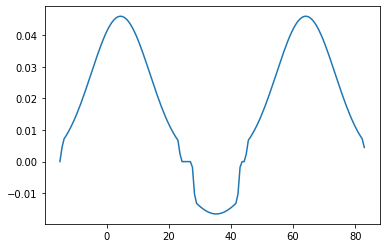

tf.Tensor((0.005940884409313396+0j), shape=(), dtype=complex128)
tf.Tensor((0.004386719151344698+0j), shape=(), dtype=complex128)
tf.Tensor((0.003954270751381883+0j), shape=(), dtype=complex128)
tf.Tensor((0.003649187826862521+0j), shape=(), dtype=complex128)
tf.Tensor((0.003393407801104864+0j), shape=(), dtype=complex128)
tf.Tensor((0.0031720674353497014+0j), shape=(), dtype=complex128)
tf.Tensor((0.0029778855247112324+0j), shape=(), dtype=complex128)
tf.Tensor((0.0028059893833451977+0j), shape=(), dtype=complex128)
tf.Tensor((0.0026528099663669646+0j), shape=(), dtype=complex128)
tf.Tensor((0.002515599125140211+0j), shape=(), dtype=complex128)
tf.Tensor((0.0023921653845829782+0j), shape=(), dtype=complex128)
tf.Tensor((0.002280715313221049+0j), shape=(), dtype=complex128)
tf.Tensor((0.0021797542331144504+0j), shape=(), dtype=complex128)
tf.Tensor((0.00208801986883822+0j), shape=(), dtype=complex128)
tf.Tensor((0.002004435740593613+0j), shape=(), dtype=complex128)
tf.Tensor((0.0019280

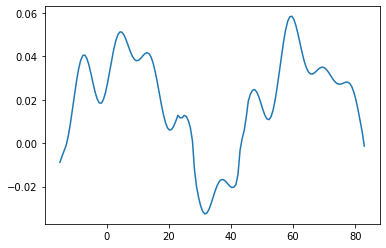

In [82]:
# 初始化脉冲
# ndarray类型的数组，不能使用*做矩阵乘法运算，应该使用@
import time
from tqdm import *
om = om_fn()
u = np.zeros(nt, dtype=np.float32) # 离散化脉冲序列
for i in range(nt):
  u[i] = om(t[i])
plt.plot(t,u)
plt.show()

u = tf.Variable(u, name='u', dtype=tf.float32) 
optimizer = tf.keras.optimizers.SGD(learning_rate=0.03)
# use tensor
adagrad = tf.Variable(tf.zeros_like(u), dtype=tf.float32)
h_diag = tf.constant(np.array(h_diag), dtype=tf.complex128)
U_ideal = tf.constant(np.array(U_ideal), dtype=tf.complex128)
eps = tf.constant(0.1 * (2 * np.pi)/t[-1], dtype=tf.float32)
dt = tf.constant(dt, dtype=tf.complex128)
for i in range(nt):
  hd_l[i] = tf.constant(np.array(hd_l[i]))
  U_l[i] = tf.constant(np.array(U_l[i]))
  Udag_l[i] = tf.constant(np.array(Udag_l[i]))
  dUdag_l[i] = tf.constant(np.array(dUdag_l[i]))
indices = tf.reshape(tf.range(9,u.shape[0]-9),shape=[u.shape[0]-18,1])
count = 0
tic = time.time()
for _ in tf.range(1000):
  U_real = tf.constant(np.array(identity(48)), dtype=tf.complex128)
  with tf.GradientTape() as tape:
    u_complex = tf.cast(u, tf.complex128)
    # FFT filter
    fft_seq = tf.signal.fft(u_complex)
    fft_filtered = fft_seq-tf.scatter_nd(indices, fft_seq[9:-9], u.shape)# 滤波
    u_filtered = tf.signal.ifft(fft_filtered) # 反傅里叶变换
    for i in tf.range(len(t)):
      h_k = h_diag + u_filtered[i] * hd_l[i]
      h_k_int = U_l[i] @ h_k @ Udag_l[i] - 1j * U_l[i] @ dUdag_l[i]
      U_tk = tf.linalg.expm(-1j * dt * h_k_int)
      U_real = U_tk @ U_real
    U_sub = tf.gather(tf.gather(U_real, com_sub, axis=0), com_sub, axis=1) # 提取subspacce
    u_real = tf.cast(tf.math.abs(U_sub), dtype=tf.complex128)
    ndim = u_real.shape[0]
    ndim = tf.cast(ndim, tf.complex128)
    M = U_ideal @ tf.linalg.adjoint(u_real)
    MMdag = M @ tf.linalg.adjoint(M)
    f = 1-(1 / (ndim * (ndim + 1))) * (tf.linalg.trace(MMdag) + tf.cast(abs(tf.linalg.trace(M) ** 2), tf.complex128))
  print(f)
  if tf.cast(f,tf.float32) < 1e-4:
    break
  df_du = tape.gradient(f, u)
  optimizer.apply_gradients(grads_and_vars=[(df_du, u)])
  count+=1
  # print("df_du:",df_du)
  # adagrad.assign(adagrad+df_du**2)
  # u.assign(u-eps/tf.sqrt(adagrad+0.000001)*df_du)
toc = time.time()
print("********************************")
print("Result: total time:{} iteration: {}".format(toc-tic, count))
print('X-PI-GATE: ', U_sub)
plt.plot(t,u.numpy())
plt.show()

NameError: ignored